<a href="https://colab.research.google.com/github/Vathsa1504/Mini-Project/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

# Move kaggle.json to the appropriate location for Kaggle API authentication
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# New Section

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection


Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
brain-mri-images-for-brain-tumor-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
import os

file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/')
    print('Done')


Done


In [ ]:
os.chdir('/content/yes')
X = []
y = []

# Process 'yes' images
import cv2
from tqdm import tqdm

for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append(1)  # 'yes' label

os.chdir('/content/no')

# Process 'no' images
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    y.append(0)  # 'no' label

# Convert to numpy arrays
import numpy as np
X = np.array(X)
y = np.array(y)

  3%|▎         | 3/100 [00:00<00:00, 144.32it/s]


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
os.chdir('/content/yes')
X = []
y = []

# Process 'yes' images
import cv2
from tqdm import tqdm

for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    # Check if the image was loaded successfully
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  # 'yes' label
    else:
        print(f"Failed to load image: {i}") # Print a message for debugging

os.chdir('/content/no')

# Process 'no' images
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    # Check if the image was loaded successfully
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  # 'no' label
    else:
        print(f"Failed to load image: {i}") # Print a message for debugging

# Convert to numpy arrays
import numpy as np
X = np.array(X)
y = np.array(y)

100%|██████████| 100/100 [00:00<00:00, 440.46it/s]

Failed to load image: brain_tumor_detection_model.h5
Failed to load image: brain-mri-images-for-brain-tumor-detection.zip


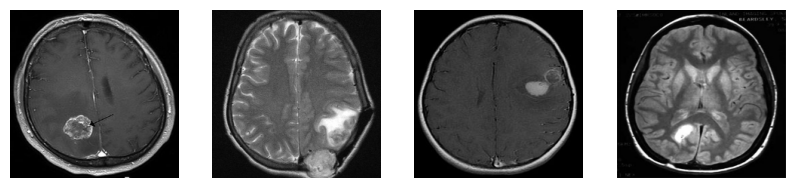

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
# Split dataset into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Normalize images to [0, 1] range
X_train = X_train / 255.0
X_test = X_test / 255.0

# One-hot encode labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Convert to categorical (one-hot encoding)
import tensorflow as tf
y_train = np.array(tf.keras.utils.to_categorical(y_train, num_classes=2))
y_test = np.array(tf.keras.utils.to_categorical(y_test, num_classes=2))

# Check shapes
print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"y_test Shape: {y_test.shape}")


X_train Shape: (169, 224, 224, 3)
X_test Shape: (84, 224, 224, 3)
y_train Shape: (169, 2)
y_test Shape: (84, 2)


In [ ]:
# Build the model using VGG16 as the base model
from keras.applications import VGG16
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model

img_rows, img_cols = 224, 224

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

# Freeze the layers of the base model
for layer in vgg.layers:
    layer.trainable = False

# Create the top model
def lw(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

num_classes = 2
FC_Head = lw(vgg, num_classes)

# Combine base model and top model
model = Model(inputs=vgg.input, outputs=FC_Head)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 589ms/step - accuracy: 0.5259 - loss: 1.1466 - val_accuracy: 0.6071 - val_loss: 0.7547
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.6760 - loss: 0.7203 - val_accuracy: 0.3929 - val_loss: 0.6906
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4293 - loss: 0.6919 - val_accuracy: 0.6071 - val_loss: 0.6415
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6225 - loss: 0.6466 - val_accuracy: 0.7857 - val_loss: 0.6162
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7604 - loss: 0.6148 - val_accuracy: 0.6071 - val_loss: 0.5679


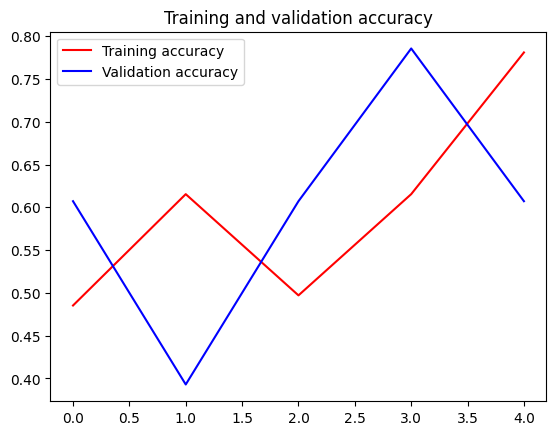

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.5809 - loss: 0.5918
Test Loss: 0.567945659160614
Test Accuracy: 0.6071428656578064


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step


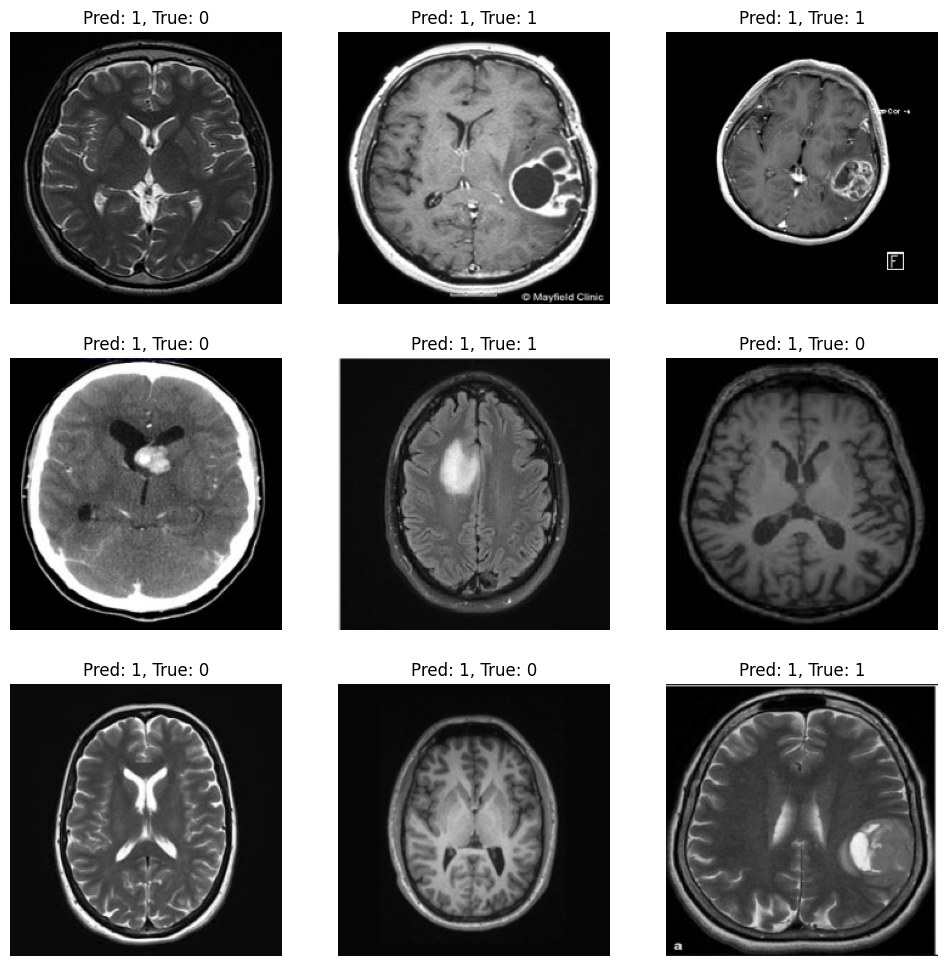

In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Display some test images with predicted and actual labels
import numpy as np

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_test[i])
    pred_label = np.argmax(predictions[i])
    true_label = np.argmax(y_test[i])
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')
plt.show()


In [ ]:
# Unfreeze some layers in the VGG16 base model
for layer in vgg.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Retrain the model
history_fine = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose=1)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 957ms/step - accuracy: 0.6237 - loss: 0.6205 - val_accuracy: 0.9048 - val_loss: 0.5156
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.7994 - loss: 0.5242 - val_accuracy: 0.8571 - val_loss: 0.4868
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7510 - loss: 0.4915 - val_accuracy: 0.8452 - val_loss: 0.4655
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.7917 - loss: 0.4633 - val_accuracy: 0.8810 - val_loss: 0.4456
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.8088 - loss: 0.4621 - val_accuracy: 0.8929 - val_loss: 0.4344


In [ ]:
# Save the model
model.save('brain_tumor_detection_model.h5')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred))

# Confusion matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'np' is not defined

In [ ]:
from google.colab import files
files.download('brain_tumor_detection_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip show tensorflow


Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras
